In [ ]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

##**Load Data Set**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP/Sentiment/training.1600000.processed.noemoticon.csv',
                 encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


##**Data Info**

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [ ]:
np.sum(df.isnull().any(axis=1))

0

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 1.17 s, sys: 6.1 ms, total: 1.18 s
Wall time: 1.37 s


Text(0.5, 1.0, 'Dataset labels distribuition')

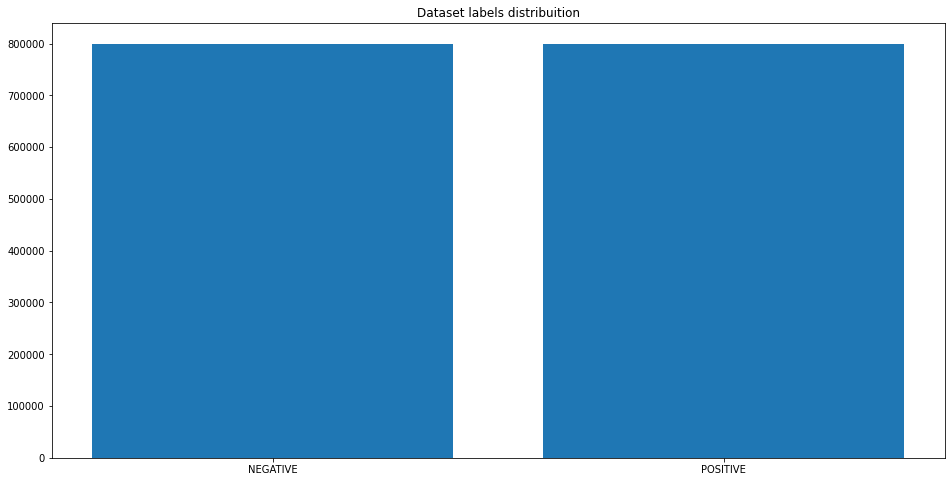

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
#import random
#random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
#df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

##**Text PreProcess**

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 7s, sys: 558 ms, total: 1min 7s
Wall time: 1min 20s


In [ ]:
#df.to_csv(r'File Name2.csv', index = False)

In [ ]:
#df.head()

##**Analysing**

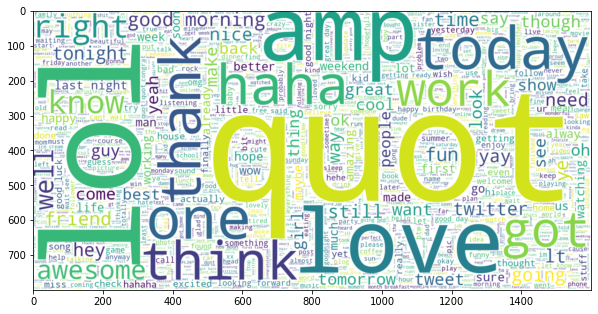

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , background_color="white").generate(" ".join(df[df.target == 'POSITIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

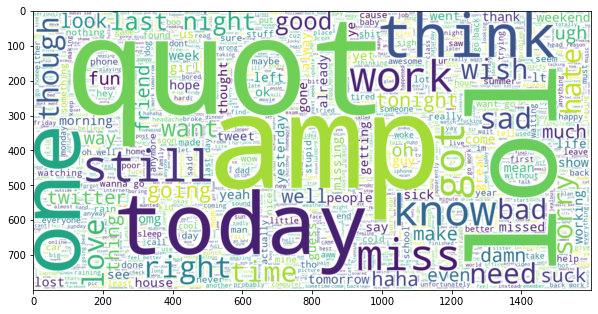

In [ ]:
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , background_color="white").generate(" ".join(df[df.target == 'NEGATIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

##**Train-Test Split**

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))


TRAIN size: 1280000
TEST size: 320000


##**Word2vec**

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.2 s, sys: 392 ms, total: 3.59 s
Wall time: 3.6 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.corpus_count

0

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 24min 9s, sys: 7.84 s, total: 24min 17s
Wall time: 13min


(263127200, 295270528)

In [ ]:
w2v_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/NLP/Sentiment/model.w2v")

In [ ]:
w2v_model.wv.most_similar("love")
#w2v_model.wv.most_similar("hate")

[('luv', 0.5800939202308655),
 ('loved', 0.5592120289802551),
 ('loves', 0.5435567498207092),
 ('adore', 0.5145546197891235),
 ('amazing', 0.5051177740097046),
 ('looove', 0.4877507984638214),
 ('awesome', 0.4716193675994873),
 ('loveee', 0.4560239017009735),
 ('miss', 0.4408932626247406),
 ('loove', 0.43962252140045166)]

##**Tokenization**

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 18.3 s, sys: 220 ms, total: 18.5 s
Wall time: 18.5 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 25.4 s, sys: 804 ms, total: 26.2 s
Wall time: 26.1 s


## **Label Encoding**

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

[4, 0, 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

## **Embedding Layer**

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH)

##**Model**

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.4))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

**“return_sequences=True” this is an important parameter while using multiple LSTM layer as it enables the output of the previous LSTM layer to be used as an input to the next LSTM layer. If it is not set to true, the next LSTM layer will not get the input.**

In [ ]:
#from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
#model = Sequential()
#model.add(embedding_layer)
#model.add(Dropout(0.5))

#model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
#model.add(Dropout(0.3))

#model.add(LSTM(32,activation='relu',dropout=0.2, recurrent_dropout=0.2,))
#model.add(Dropout(0.3))

#model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.2))

#model.add(Dense(1, activation='softmax'))

#model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout_52 (Dropout)        (None, 300, 300)          0         
                                                                 
 lstm_28 (LSTM)              (None, 300, 128)          219648    
                                                                 
 dropout_53 (Dropout)        (None, 300, 128)          0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_54 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 32)              

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
  74/1125 [>.............................] - ETA: 24:25 - loss: 0.5987 - accuracy: 0.6734

##**Evaluating**

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 79s 252ms/step - loss: 0.4439 - accuracy: 0.7911

ACCURACY: 0.791071891784668
LOSS: 0.443861186504364
CPU times: user 52.6 s, sys: 20.2 s, total: 1min 12s
Wall time: 1min 19s


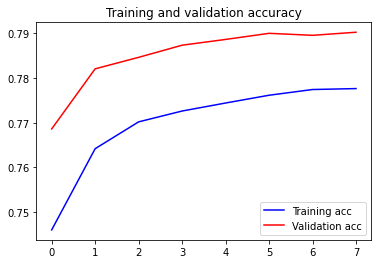

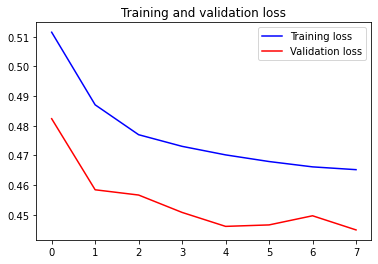

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

##**Save model and load**

In [ ]:
model.save(KERAS_MODEL)
#w2v_model.save(WORD2VEC_MODEL)
#pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
#pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [ ]:
#from keras.models import load_model
#model = load_model('/content/drive/MyDrive/NLP/Sentiment/lstm_79.08.h5')

##**Predict**

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'elapsed_time': 0.4410207271575928,
 'label': 'POSITIVE',
 'score': 0.9670817255973816}

In [ ]:
predict("I hate the rain")

{'elapsed_time': 0.1621248722076416,
 'label': 'NEGATIVE',
 'score': 0.00966703426092863}

In [ ]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.15554237365722656,
 'label': 'NEGATIVE',
 'score': 0.3446689546108246}

In [ ]:
predict("i am not okay")

{'elapsed_time': 0.16028165817260742,
 'label': 'NEUTRAL',
 'score': 0.5458383560180664}

In [ ]:
predict("i like it")

{'elapsed_time': 0.15333271026611328,
 'label': 'POSITIVE',
 'score': 0.7073832750320435}